# Задание

В файле тестовая задача. Заданы 3 столбца — дата, объем, температура.
Необходимо:
разделить данные на train, test.
На этих данных необходимо построить модели, прогнозирующие объем на 7-й день вперед относительно момента прогнозирования при условии, что на день прогноза известна температура и вся ретроспективная информация по температуре и объему относительно момента прогнозирования
 
Предлагается использование различных методов — классических моделей, нейросетей.

Работа с признаками, к примеру — объем сутки назад нам не будет известен на даты прогноза, а 2 недели — будет.

# Библиотеки

In [1]:
import sklearn
import tabulate
import datetime
import statsmodels
import statsmodels.api as sm

from scipy.optimize import brute

#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#import os
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from scipy.stats import spearmanr, ttest_ind

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from tabulate import tabulate
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm


from arch import arch_model

from scipy.stats import shapiro

In [2]:
#%autosave 360

# Выгрузка таблички

In [3]:
# Загрузка файла CSV в DataFrame
file_path = 'C:/Users/user/Downloads/T.csv'
df = pd.read_csv(file_path, delimiter=';')

# Вывод таблицы
table = tabulate(df.head(), headers='keys', tablefmt='fancy_grid')
print(table)

╒════╤════════════╤═══════╤═════╕
│    │ Date       │     Q │   T │
╞════╪════════════╪═══════╪═════╡
│  0 │ 01.01.2010 │ 38802 │ -18 │
├────┼────────────┼───────┼─────┤
│  1 │ 02.01.2010 │ 40640 │ -21 │
├────┼────────────┼───────┼─────┤
│  2 │ 03.01.2010 │ 42614 │ -28 │
├────┼────────────┼───────┼─────┤
│  3 │ 04.01.2010 │ 42587 │ -21 │
├────┼────────────┼───────┼─────┤
│  4 │ 05.01.2010 │ 42783 │ -10 │
╘════╧════════════╧═══════╧═════╛


# Выделение массивов объёма и температуры

In [4]:
# Преобразоание столбцов DataFrame в массивы numpy
v = df['Q'].values  
t = df['T'].values  
d = df['Date'].values  

# Вывод первых 5 элементов массива v
print(v[:5])
print(t[:5])
print(d[:5])

[38802 40640 42614 42587 42783]
[-18 -21 -28 -21 -10]
['01.01.2010' '02.01.2010' '03.01.2010' '04.01.2010' '05.01.2010']


In [5]:
df_tv = pd.DataFrame({'t': t, 'v': v})
print(df_tv)

row_tv = df_tv.iloc[-1]
print(row_tv)

row_tv_test = df_tv.iloc[-8]
print(row_tv_test)

row_test = df_tv[-8:-7]
print(row_test)

       t      v
0    -18  38802
1    -21  40640
2    -28  42614
3    -21  42587
4    -10  42783
...   ..    ...
4013  -5  86381
4014  -9  87427
4015  -6  87800
4016  -4  82136
4017  -2  76990

[4018 rows x 2 columns]
t       -2
v    76990
Name: 4017, dtype: int64
t       -1
v    80078
Name: 4010, dtype: int64
      t      v
4010 -1  80078


# Преобразование даты в номер дня в году и в номер месяца

In [6]:
date_obj = []
day_of_year = []
month_number = []

for i in range(len(d)):
    # Преобразование строки в объект datetime
    date_obj.append(datetime.strptime(d[i], "%d.%m.%Y"))
    # номер дня в году
    day_of_year.append(date_obj[i].timetuple().tm_yday)
    # номер месяца
    month_number.append(date_obj[i].month)
    
print(day_of_year[:5])
print(month_number[:5])  

[1, 2, 3, 4, 5]
[1, 1, 1, 1, 1]


In [7]:
# Объединение в один двумерный массив
_t_ = np.column_stack((month_number, day_of_year, t))

print(_t_[:5])

[[  1   1 -18]
 [  1   2 -21]
 [  1   3 -28]
 [  1   4 -21]
 [  1   5 -10]]


In [8]:
# Определение процентного разделения (80% на обучение, 20% на тест)
#split_percentage = 0.8

# Разделение данных на обучающий и тестовый наборы
#split_index = int(len(t) * split_percentage)
tt_train = t[:-7]
tt_test = t[-7:]

#
print(tt_test)

[-1 -2 -5 -9 -6 -4 -2]


# Прогнозирование температуры случайным лесом

# Обучение предсказания температуры на обучающей выборке

In [9]:
"""# Создание DataFrame из исходных данных
df_tv = pd.DataFrame(df_tv, columns=['t', 'v'])
z1 = 10    # размер исторического периода
# Создание новых колонок с 10 предыдущими значениями t и v
for i in range(1, z1+1):
    df_tv[f't_{i}'] = df_tv['t'].shift(i)
    
for i in range(1, z1+1):
    df_tv[f'v_{i}'] = df_tv['v'].shift(i)
    
df_tv = df_tv[z1:]

# Вырезание столбца t 
#t_array = df['t'].values
#df_tv = df_tv.drop(columns=['t'])

#t_end = t_array[-1]

#t_array_test = df_test['t'].values
#df_test = df_test.drop(columns=['t'])

print(df_tv)"""

"# Создание DataFrame из исходных данных\ndf_tv = pd.DataFrame(df_tv, columns=['t', 'v'])\nz1 = 10    # размер исторического периода\n# Создание новых колонок с 10 предыдущими значениями t и v\nfor i in range(1, z1+1):\n    df_tv[f't_{i}'] = df_tv['t'].shift(i)\n    \nfor i in range(1, z1+1):\n    df_tv[f'v_{i}'] = df_tv['v'].shift(i)\n    \ndf_tv = df_tv[z1:]\n\n# Вырезание столбца t \n#t_array = df['t'].values\n#df_tv = df_tv.drop(columns=['t'])\n\n#t_end = t_array[-1]\n\n#t_array_test = df_test['t'].values\n#df_test = df_test.drop(columns=['t'])\n\nprint(df_tv)"

In [10]:
print(df_tv)

       t      v
0    -18  38802
1    -21  40640
2    -28  42614
3    -21  42587
4    -10  42783
...   ..    ...
4013  -5  86381
4014  -9  87427
4015  -6  87800
4016  -4  82136
4017  -2  76990

[4018 rows x 2 columns]


In [11]:
# Создание DataFrame из исходных данных
df = pd.DataFrame(_t_, columns=['d1', 'd2', 't'])

z = 20    # размер исторического периода
# Создание новых колонок с 10 предыдущими значениями t
for i in range(1, z+1):
    df[f't_{i}'] = df['t'].shift(i)
    
dfdf = df
dfdf = dfdf.drop(columns=['t'])
#df = df.iloc[10:-7] # tt_train
df_test = df[-7:] # tt_test
df = df[z:-7] # tt_train

# Вырезание столбца t 
t_array = df['t'].values
df = df.drop(columns=['t'])

t_end = t_array[-1]

t_array_test = df_test['t'].values
df_test = df_test.drop(columns=['t'])

print(df)

      d1   d2   t_1   t_2   t_3   t_4   t_5   t_6   t_7   t_8  ...  t_11  \
20     1   21 -26.0 -25.0 -20.0 -10.0  -9.0  -7.0  -8.0  -7.0  ... -16.0   
21     1   22 -22.0 -26.0 -25.0 -20.0 -10.0  -9.0  -7.0  -8.0  ... -16.0   
22     1   23 -26.0 -22.0 -26.0 -25.0 -20.0 -10.0  -9.0  -7.0  ... -11.0   
23     1   24 -28.0 -26.0 -22.0 -26.0 -25.0 -20.0 -10.0  -9.0  ...  -7.0   
24     1   25 -26.0 -28.0 -26.0 -22.0 -26.0 -25.0 -20.0 -10.0  ...  -8.0   
...   ..  ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4006  12  355  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  -8.0  ...  -7.0   
4007  12  356  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  ...  -6.0   
4008  12  357   2.0  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  ...  -8.0   
4009  12  358   0.0   2.0  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  ...  -8.0   
4010  12  359   0.0   0.0   2.0  -1.0  -3.0   0.0  -1.0  -3.0  ...  -3.0   

      t_12  t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
20   -16.0  -8.0 -14.0 -12

In [12]:
print(df_test)

      d1   d2  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_11  t_12  t_13  \
4011  12  360 -1.0  0.0  0.0  2.0 -1.0 -3.0  0.0 -1.0  ...  -8.0  -3.0  -8.0   
4012  12  361 -1.0 -1.0  0.0  0.0  2.0 -1.0 -3.0  0.0  ...  -4.0  -8.0  -3.0   
4013  12  362 -2.0 -1.0 -1.0  0.0  0.0  2.0 -1.0 -3.0  ...  -3.0  -4.0  -8.0   
4014  12  363 -5.0 -2.0 -1.0 -1.0  0.0  0.0  2.0 -1.0  ...  -1.0  -3.0  -4.0   
4015  12  364 -9.0 -5.0 -2.0 -1.0 -1.0  0.0  0.0  2.0  ...   0.0  -1.0  -3.0   
4016  12  365 -6.0 -9.0 -5.0 -2.0 -1.0 -1.0  0.0  0.0  ...  -3.0   0.0  -1.0   
4017  12  366 -4.0 -6.0 -9.0 -5.0 -2.0 -1.0 -1.0  0.0  ...  -1.0  -3.0   0.0   

      t_14  t_15  t_16  t_17  t_18  t_19  t_20  
4011  -8.0  -6.0  -7.0  -3.0   1.0   0.0  -2.0  
4012  -8.0  -8.0  -6.0  -7.0  -3.0   1.0   0.0  
4013  -3.0  -8.0  -8.0  -6.0  -7.0  -3.0   1.0  
4014  -8.0  -3.0  -8.0  -8.0  -6.0  -7.0  -3.0  
4015  -4.0  -8.0  -3.0  -8.0  -8.0  -6.0  -7.0  
4016  -3.0  -4.0  -8.0  -3.0  -8.0  -8.0  -6.0  
4017  -1.0  -3.0

In [13]:
print(t_array)

[-22 -26 -28 ...   0   0  -1]


In [14]:
print(t_array_test)

[-1 -2 -5 -9 -6 -4 -2]


In [15]:
# Создание модели случайного леса
rf_model = RandomForestRegressor(random_state=42)

In [16]:
"""# Определение параметров для проверки
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None]
}

# Создание GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Поиск по параметрам
grid_search.fit(df, t_array)

print("Лучшие параметры:", grid_search.best_params_)"""

'# Определение параметров для проверки\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [10, 20, 30, None]\n}\n\n# Создание GridSearchCV\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=\'neg_mean_squared_error\')\n\n# Поиск по параметрам\ngrid_search.fit(df, t_array)\n\nprint("Лучшие параметры:", grid_search.best_params_)'

In [17]:
# Лучшие параметры
best_params = {'max_depth': 10, 'n_estimators': 300}

# Новый экземпляр модели с лучшими параметрами
rf_model1 = RandomForestRegressor(random_state=42, **best_params)


In [18]:
# Обучение модели на обучающей выборке
rf_model1.fit(df, t_array)

RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42)

In [19]:
# Предсказание на тестовых данных
t_pred = rf_model1.predict(df_test)

In [20]:
# Оценка модели
mae = mean_absolute_error(t_array_test, t_pred)
mse = mean_squared_error(t_array_test, t_pred)
r2 = r2_score(t_array_test, t_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

MAE: 2.1082840247221113
MSE: 6.00561626907142
R-squared: 0.10281952077896472


In [21]:
real_values = np.array(t_array_test)
predicted_values = np.array(t_pred)

spearman_corr, p_value = spearmanr(real_values, predicted_values)

print(f"Spearman корреляция: {spearman_corr}")
print(f"p-значение: {p_value}")

t_statistic, p_value = ttest_ind(real_values, predicted_values)
print(f"t-критерий: {t_statistic}")
print(f"p-значение: {p_value}")

Spearman корреляция: 0.6666937223947136
p-значение: 0.10192046024618232
t-критерий: -0.24255517908484037
p-значение: 0.8124460995392737


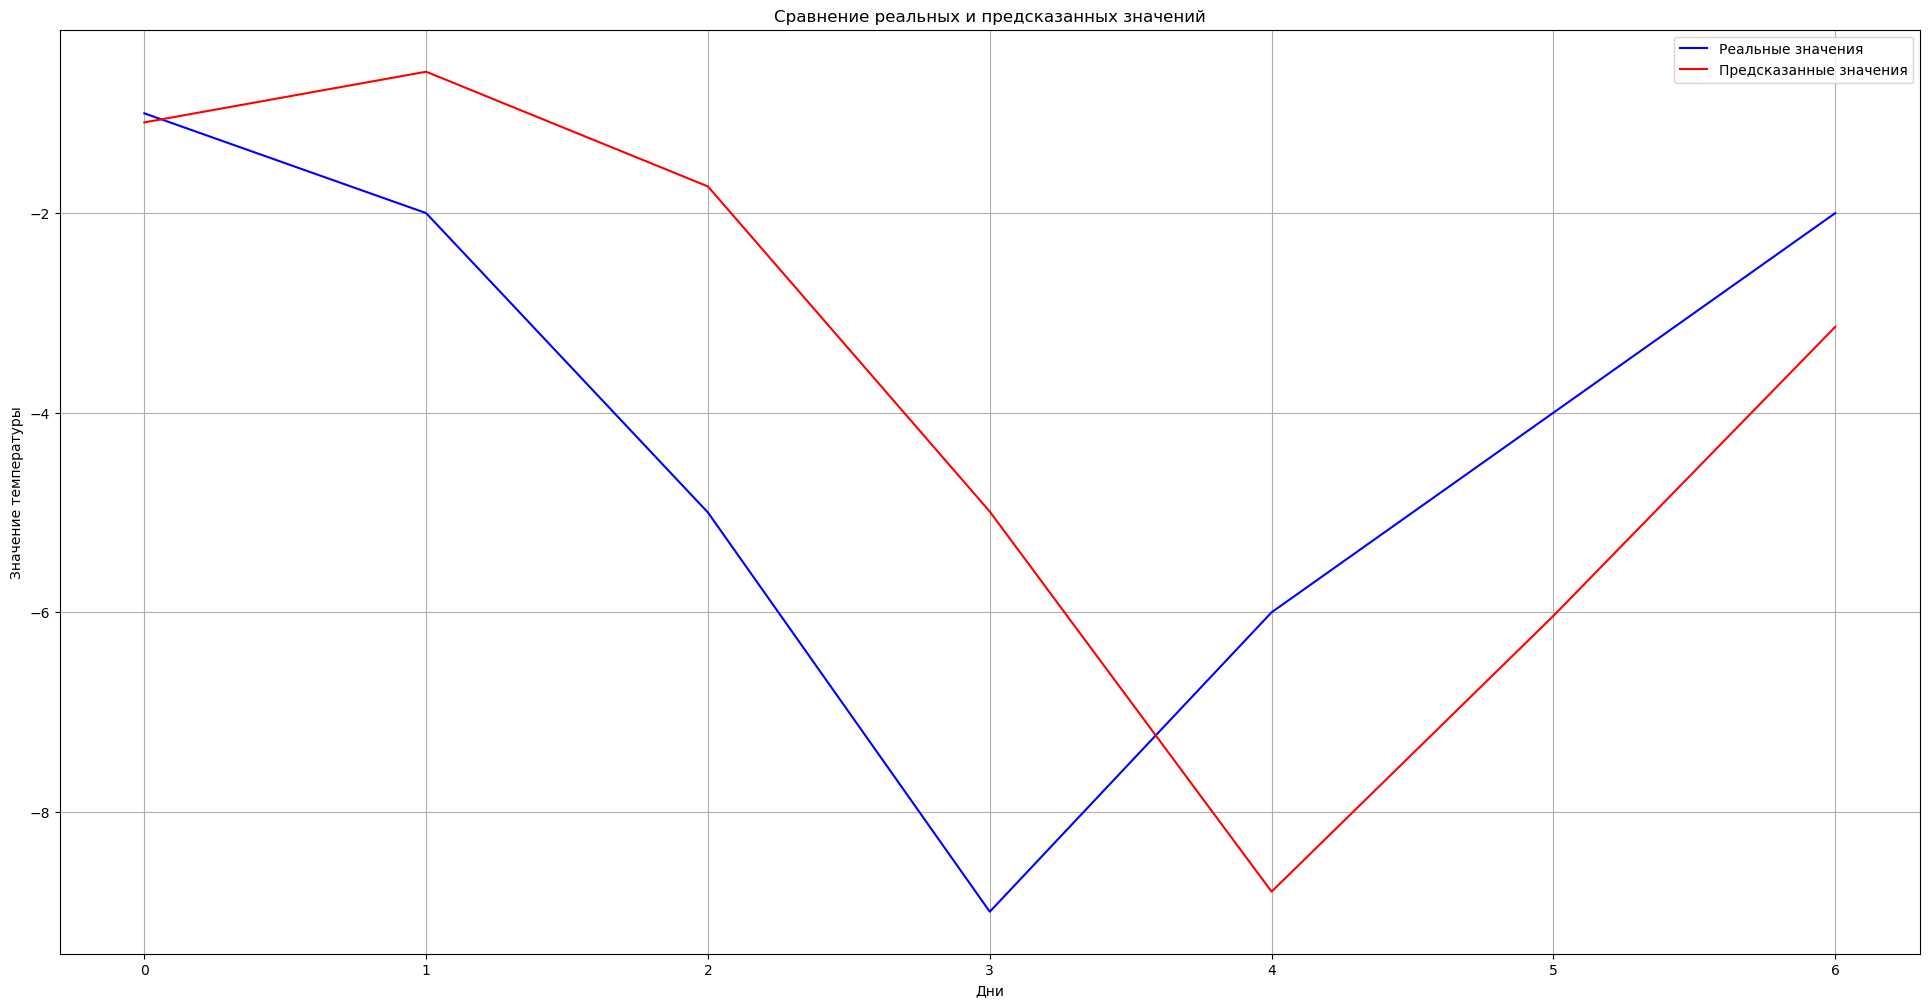

In [22]:
# график
plt.figure(figsize=(24, 12))
plt.plot(t_array_test, label='Реальные значения', color='blue')
plt.plot(t_pred, label='Предсказанные значения', color='red')

plt.xlabel('Дни')
plt.ylabel('Значение температуры')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
num_ = 5
# кросс-валидация
scores = cross_val_score(rf_model1, df, t_array, cv=num_, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()

print("Среднее MSE:", mean_mse)

Среднее MSE: 7.369875742994151


# Предсказание температуры с предсказанием на каждый день ТЕСТ (на 7 дней)

In [24]:
# Число предсказываемых дней
num_days_to_predict = 7
t7 = []
t_end = t[-8]

for _ in range(num_days_to_predict):
    # новая строка для предсказаний
    new_row = df.iloc[-1].copy()


    if (df.iloc[-29:]['d1'] == new_row['d1']).all():
        new_row['d1'] += 1  
    else: new_row['d1'] = 1
    
    if new_row['d1'] > 12:
        new_row['d1'] = 1
    
    if new_row['d2'] >= 365:
        new_row['d2'] = 1
    else:
        new_row['d2'] += 1
    
    
    # Сдвиг значения t
    for i in range(2, z+1):
        new_row[f't_{i}'] = df.iloc[-1][f't_{i - 1}']
    new_row[f't_1'] = t_end

    df = pd.concat([df, new_row.to_frame().T], ignore_index=True) 

    print(df[-2:-1])  
    
    # Получение последней строки в массиве df
    last_row = df.iloc[-1]

    feature_names = ['d1', 'd2', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18', 't_19', 't_20']
    last_row_df = pd.DataFrame([last_row.values], columns=feature_names)

    
    # Прогнозирование значения t для последней строки
    temperature_forecast = rf_model1.predict(last_row_df)
    t_end = temperature_forecast
    
    t7 = np.append(t7, temperature_forecast)


        d1     d2  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_11  t_12  \
3990  12.0  359.0  0.0  0.0  2.0 -1.0 -3.0  0.0 -1.0 -3.0  ...  -3.0  -8.0   

      t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
3990  -8.0  -6.0  -7.0  -3.0   1.0   0.0  -2.0  -2.0  

[1 rows x 22 columns]
       d1     d2  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_11  t_12  \
3991  1.0  360.0 -1.0  0.0  0.0  2.0 -1.0 -3.0  0.0 -1.0  ...  -8.0  -3.0   

      t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
3991  -8.0  -8.0  -6.0  -7.0  -3.0   1.0   0.0  -2.0  

[1 rows x 22 columns]
       d1     d2       t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_11  \
3992  1.0  361.0 -1.105181 -1.0  0.0  0.0  2.0 -1.0 -3.0  0.0  ...  -4.0   

      t_12  t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
3992  -8.0  -3.0  -8.0  -8.0  -6.0  -7.0  -3.0   1.0   0.0  

[1 rows x 22 columns]
       d1     d2       t_1       t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_11  \
3993  1.0  362.0 -0.587607 -1.105181 -1.0  

In [25]:
print(t7)

[-1.10518126 -0.5876069  -0.85402489 -1.07229472 -1.00940398 -1.0218555
 -1.04171609]


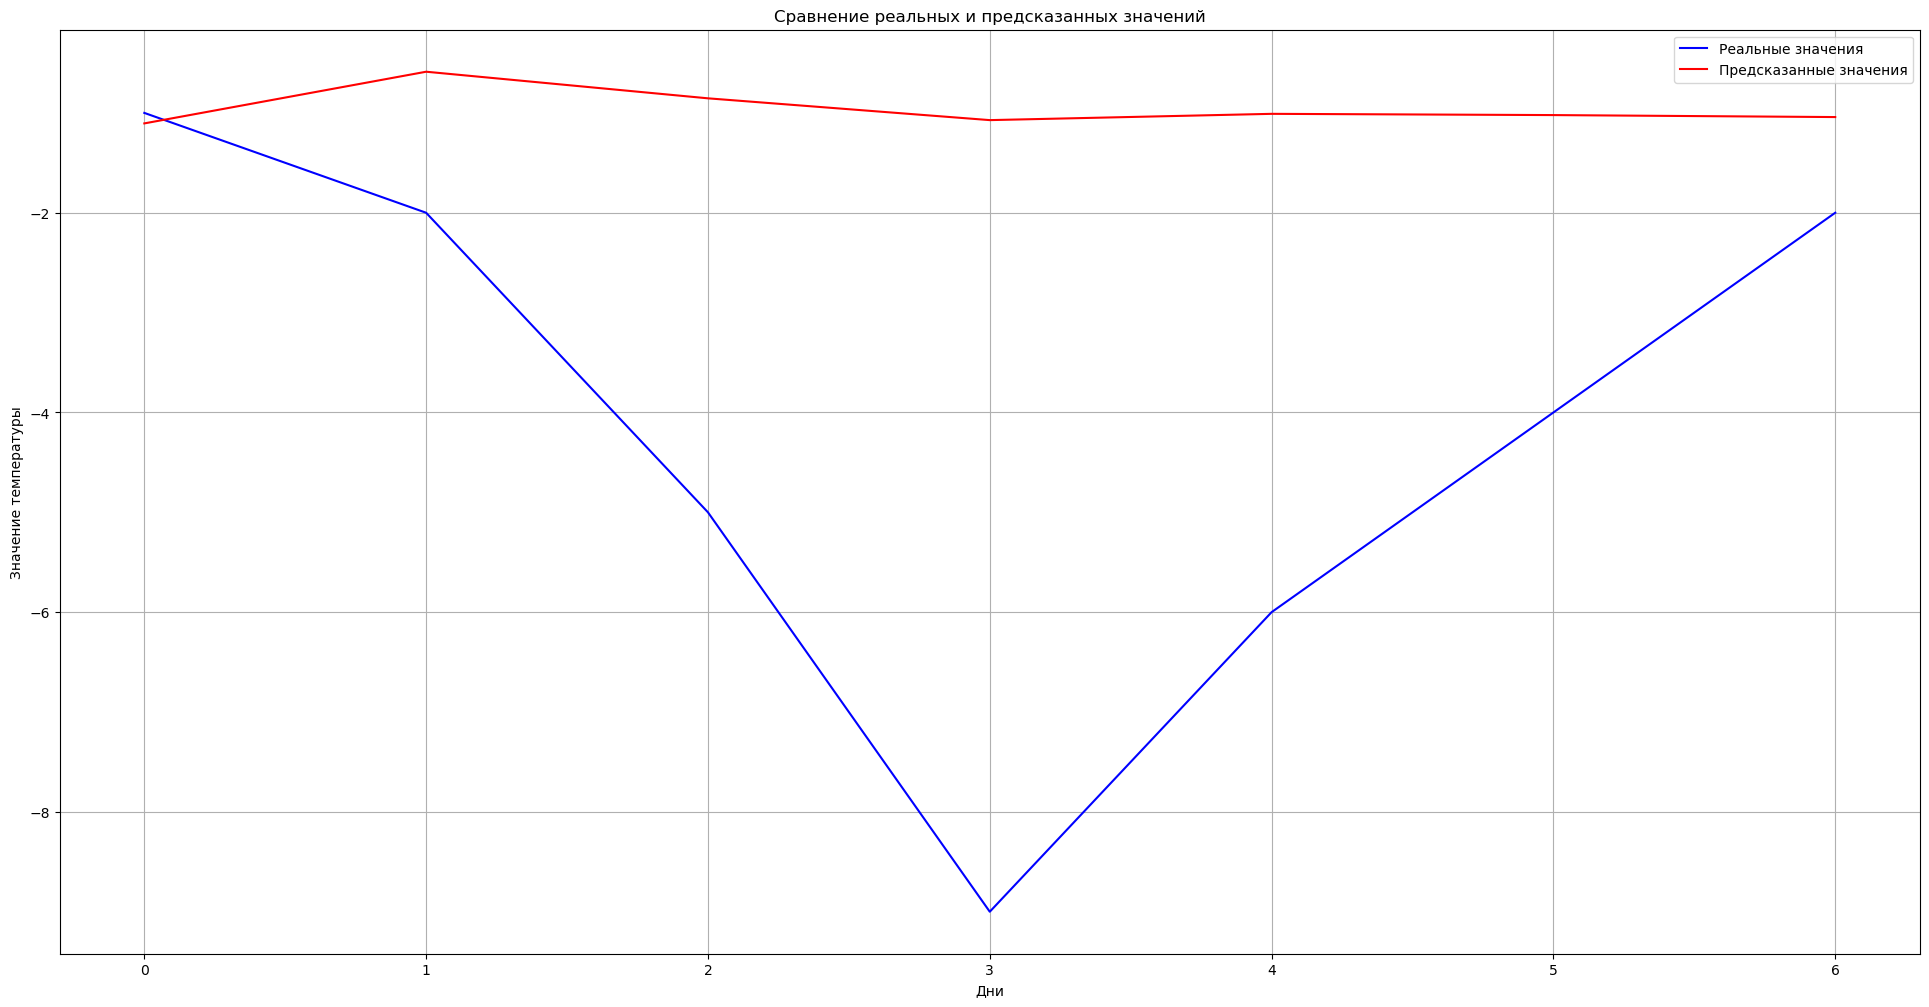

In [26]:
# график
plt.figure(figsize=(24, 12))
plt.plot(t_array_test, label='Реальные значения', color='blue')
plt.plot(t7, label='Предсказанные значения', color='red')

plt.xlabel('Дни')
plt.ylabel('Значение температуры')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
real_values = np.array(t_array_test)
predicted_values = np.array(t7)

spearman_corr, p_value = spearmanr(real_values, predicted_values)

print(f"Spearman корреляция: {spearman_corr}")
print(f"p-значение: {p_value}")

t_statistic, p_value = ttest_ind(real_values, predicted_values)
print(f"t-критерий: {t_statistic}")
print(f"p-значение: {p_value}")

Spearman корреляция: -0.14414999403128945
p-значение: 0.7578179356488596
t-критерий: -3.010851421033284
p-значение: 0.010845756648092128


# Предсказание температуры на будущее (7 дней)

In [28]:
# Число предсказываемых дней
num_days_to_predict = 7
t7p = []
t_end = t[-1]

for _ in range(num_days_to_predict):
    # новая строка для предсказаний
    new_row = dfdf.iloc[-1].copy()


    if (dfdf.iloc[-29:]['d1'] == new_row['d1']).all():
        new_row['d1'] += 1  
    else: new_row['d1'] = 1
    
    if new_row['d1'] > 12:
        new_row['d1'] = 1
    
    if new_row['d2'] >= 365:
        new_row['d2'] = 1
    else:
        new_row['d2'] += 1
    
    
    # Сдвиг значения t
    for i in range(2, z+1):
        new_row[f't_{i}'] = dfdf.iloc[-1][f't_{i - 1}']
    new_row[f't_1'] = t_end

    dfdf = pd.concat([dfdf, new_row.to_frame().T], ignore_index=True) 

    print(df[-2:-1])  
    
    # Получение последней строки в массиве df
    last_row = dfdf.iloc[-1]

    feature_names = ['d1', 'd2', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18', 't_19', 't_20']
    last_row_df = pd.DataFrame([last_row.values], columns=feature_names)

    
    # Прогнозирование значения t для последней строки
    temperature_forecast = rf_model1.predict(last_row_df)
    t_end = temperature_forecast
    
    t7p = np.append(t7p, temperature_forecast)

       d1     d2       t_1       t_2       t_3       t_4       t_5  t_6  t_7  \
3996  1.0  365.0 -1.009404 -1.072295 -0.854025 -0.587607 -1.105181 -1.0  0.0   

      t_8  ...  t_11  t_12  t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
3996  0.0  ...  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  -8.0  -8.0  -6.0  

[1 rows x 22 columns]
       d1     d2       t_1       t_2       t_3       t_4       t_5  t_6  t_7  \
3996  1.0  365.0 -1.009404 -1.072295 -0.854025 -0.587607 -1.105181 -1.0  0.0   

      t_8  ...  t_11  t_12  t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
3996  0.0  ...  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  -8.0  -8.0  -6.0  

[1 rows x 22 columns]
       d1     d2       t_1       t_2       t_3       t_4       t_5  t_6  t_7  \
3996  1.0  365.0 -1.009404 -1.072295 -0.854025 -0.587607 -1.105181 -1.0  0.0   

      t_8  ...  t_11  t_12  t_13  t_14  t_15  t_16  t_17  t_18  t_19  t_20  
3996  0.0  ...  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  -8.0  -8.0  -6.0  

[1 rows 

In [29]:
print(t7p)

[-2.01775821 -3.08327569 -4.23276701 -3.6593758  -3.16602306 -2.93379007
 -4.1162641 ]


## Обучение модели случайного леса для ОБЪЁМА

In [30]:
print(df_tv)
print(t)

       t      v
0    -18  38802
1    -21  40640
2    -28  42614
3    -21  42587
4    -10  42783
...   ..    ...
4013  -5  86381
4014  -9  87427
4015  -6  87800
4016  -4  82136
4017  -2  76990

[4018 rows x 2 columns]
[-18 -21 -28 ...  -6  -4  -2]


In [31]:
z1 = 10  # размер исторического периода

# Создание новых колонок с z1 предыдущими значениями t
for i in range(1, z1+1):
    df_tv[f't_{i}'] = df_tv['t'].shift(i)
    
# Создание новых колонок с z1 предыдущими значениями V
for i in range(1, z1+1):
    df_tv[f'v_{i}'] = df_tv['v'].shift(i)

df_tv_7 = df_tv

df_tv_test = df_tv[-7:] # tt_test
df_tv = df_tv[z1:-7] # tt_train


# Вырезание столбца V 
v_array = df_tv['v'].values
df_tv = df_tv.drop(columns=['v'])

v_array_test = df_tv_test['v'].values
df_tv_test = df_tv_test.drop(columns=['v'])
    
print(df_tv)
print(v_array)

       t   t_1   t_2   t_3   t_4   t_5   t_6   t_7   t_8   t_9  ...      v_1  \
10   -16 -16.0 -16.0  -8.0 -14.0 -12.0 -10.0 -21.0 -28.0 -21.0  ...  42550.0   
11   -11 -16.0 -16.0 -16.0  -8.0 -14.0 -12.0 -10.0 -21.0 -28.0  ...  42083.0   
12    -7 -11.0 -16.0 -16.0 -16.0  -8.0 -14.0 -12.0 -10.0 -21.0  ...  39315.0   
13    -8  -7.0 -11.0 -16.0 -16.0 -16.0  -8.0 -14.0 -12.0 -10.0  ...  38619.0   
14    -7  -8.0  -7.0 -11.0 -16.0 -16.0 -16.0  -8.0 -14.0 -12.0  ...  38494.0   
...   ..   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...      ...   
4006  -1  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  -8.0  -8.0  ...  82808.0   
4007   2  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  -8.0  ...  81149.0   
4008   0   2.0  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  -3.0  ...  81902.0   
4009   0   0.0   2.0  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  -8.0  ...  80984.0   
4010  -1   0.0   0.0   2.0  -1.0  -3.0   0.0  -1.0  -3.0  -4.0  ...  81859.0   

          v_2      v_3      v_4      v_

In [32]:
"""# двумерный массив, где V в строке будет содержать V из предыдущей строки (срезы массива)
v_prev = np.roll(v, shift=1)
v_prev[0] = 0  # значение в первой строке (предыдущего значения нет)
two_0_array = np.column_stack((v_prev, t))

# Удаление первой и последней строки
two_array = two_0_array[1:-1]
v_ = v[1:-1]

print(two_array[:5])
print(v_)
print(v_[-7:])"""

'# двумерный массив, где V в строке будет содержать V из предыдущей строки (срезы массива)\nv_prev = np.roll(v, shift=1)\nv_prev[0] = 0  # значение в первой строке (предыдущего значения нет)\ntwo_0_array = np.column_stack((v_prev, t))\n\n# Удаление первой и последней строки\ntwo_array = two_0_array[1:-1]\nv_ = v[1:-1]\n\nprint(two_array[:5])\nprint(v_)\nprint(v_[-7:])'

In [33]:
"""df_tv = pd.DataFrame({'t': t, 'v': v})
print(df_tv)"""

"df_tv = pd.DataFrame({'t': t, 'v': v})\nprint(df_tv)"

# Обучение модели и тестирование на большом объёме данных

In [34]:
# 80% на обучение, 20% на тест ТЕСТИРОВАНИЕ № 1 НА БОЛЬШОМ ОБЪЁМЕ ДАННЫХ
split_percentage = 0.8

split_index = int(len(t) * split_percentage)
x_train = df_tv[:split_index]
x_test = df_tv[split_index:]

split_index = int(len(v) * split_percentage)
v_train = v_array[:split_index]
v_test = v_array[split_index:]

In [35]:
"""param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20]
}
# Мдель случайного леса (кол-во деревьев в лесу, глубина каждого дерева и т.д.)
rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, v_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# обучение модели
best_model.fit(x_train, v_train)"""


"param_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [1, 5, 10, 15, 20],\n    'min_samples_split': [2, 5, 10, 20]\n}\n# Мдель случайного леса (кол-во деревьев в лесу, глубина каждого дерева и т.д.)\nrf_model = RandomForestRegressor()\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')\n\ngrid_search.fit(x_train, v_train)\n\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\n# обучение модели\nbest_model.fit(x_train, v_train)"

In [36]:
# Модель случайного леса (кол-во деревьев в лесу, глубина каждого дерева и т.д.)
rf_model = RandomForestRegressor()

In [37]:
#max_depth=10, min_samples_split=20, n_estimators=50

# Лучшие параметры
best_params = {'max_depth': 10, 'n_estimators': 50,  'min_samples_split':20}

# Новый экземпляр модели с лучшими параметрами
best_model = RandomForestRegressor(**best_params)

In [38]:
# обучение модели
best_model.fit(x_train, v_train)

RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50)

In [39]:
v_pred = best_model.predict(x_test)

print(v_pred[:10]) # вывод первых 10 значений для примера

[75388.82438508 73058.01850949 71404.55622791 68433.00926186
 66675.80170412 66611.544387   65346.01226088 66543.87902097
 66369.64551787 67217.08020913]


In [40]:
# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(v_test, v_pred)

# Средняя квадратичная ошибка (MSE)
mse = mean_squared_error(v_test, v_pred)

# Вычисление R^2 для модели
r2 = r2_score(v_test, v_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print("R^2:", r2)

MAE: 2137.4844173423035
MSE: 8899554.604486875
R^2: 0.9686261630487484


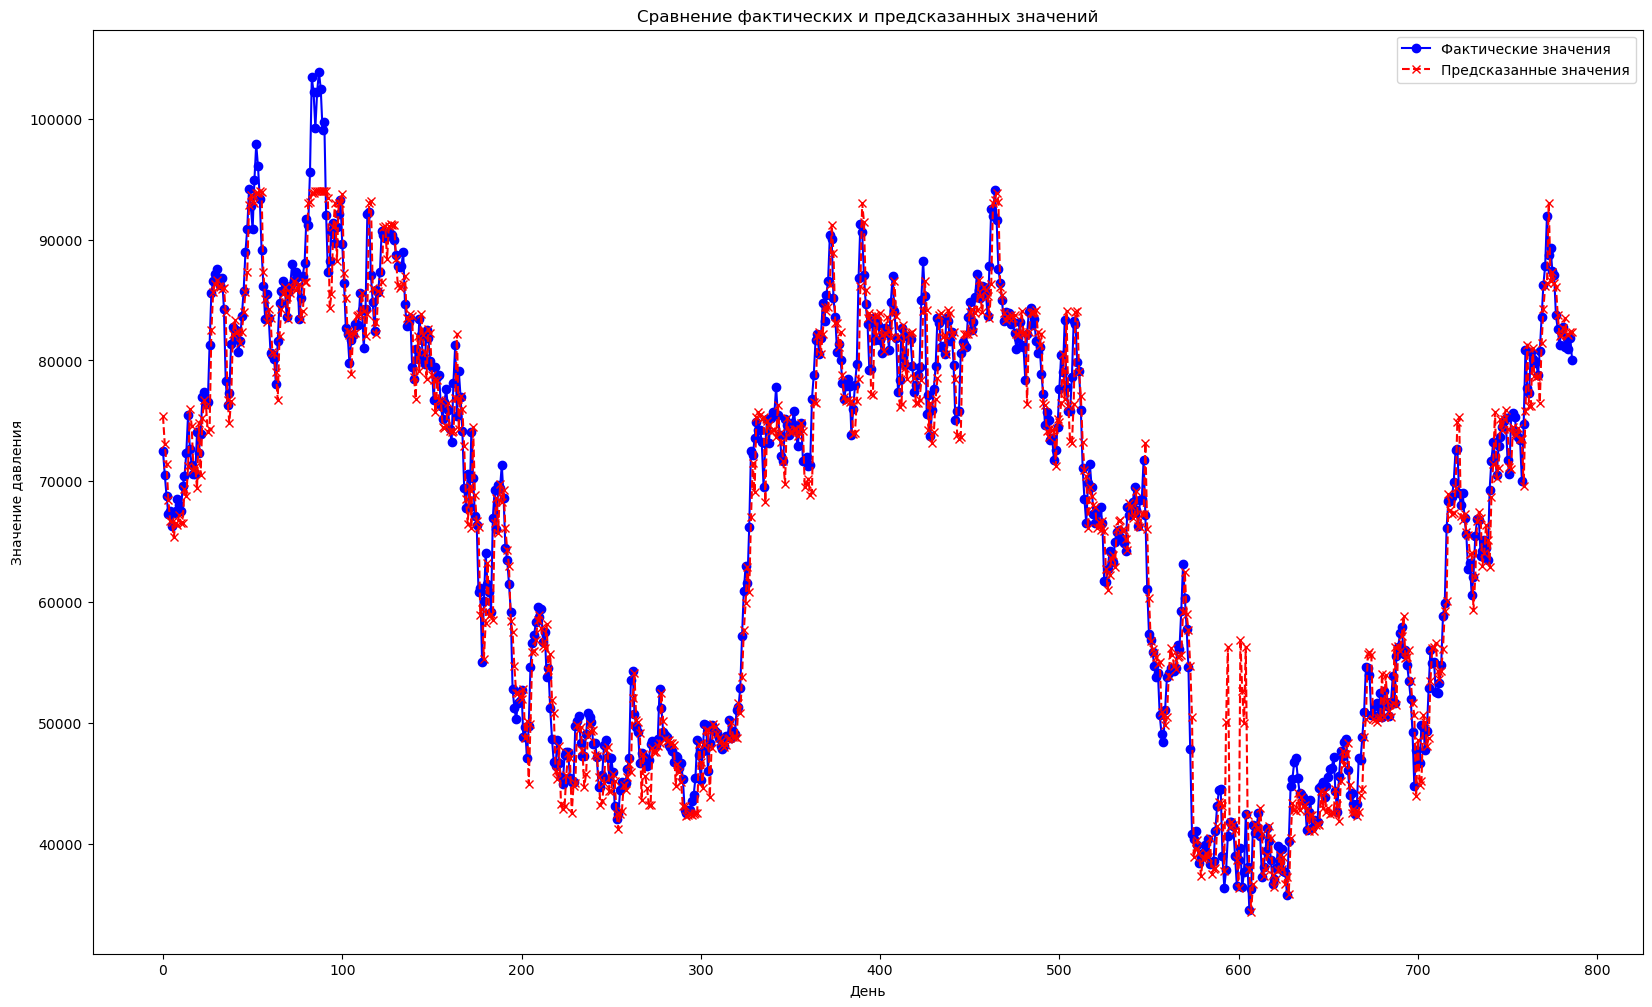

In [60]:
# график
plt.figure(figsize=(20, 12))

plt.plot(v_test, label='Фактические значения', marker='o', linestyle='-', color='b')
plt.plot(v_pred, label='Предсказанные значения', marker='x', linestyle='--', color='r')

plt.xlabel('День')
plt.ylabel('Значение давления')
plt.legend(loc='best')

plt.title('Сравнение фактических и предсказанных значений')

plt.show()

In [42]:
num_ = 100
# кросс-валидация
scores = cross_val_score(best_model, x_train, v_train, cv=num_, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()

print("Среднее MSE:", mean_mse)

Среднее MSE: 7174405.580665859


# Прогнозирование объёма по температуре (тестирование) - 7 дней

In [43]:
print(t7)

[-1.10518126 -0.5876069  -0.85402489 -1.07229472 -1.00940398 -1.0218555
 -1.04171609]


In [44]:
print(t[-7:])
print(v[-7:])

[-1 -2 -5 -9 -6 -4 -2]
[84676 87027 86381 87427 87800 82136 76990]


In [45]:
# обучение модели на других данных
best_model.fit(df_tv, v_array)

RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50)

In [46]:
v_end = v[-8]
print(v_end)

80078


In [47]:
new_row = df_tv.iloc[-1].copy()
print(new_row)

t          -1.0
t_1         0.0
t_2         0.0
t_3         2.0
t_4        -1.0
t_5        -3.0
t_6         0.0
t_7        -1.0
t_8        -3.0
t_9        -4.0
t_10       -8.0
v_1     81859.0
v_2     80984.0
v_3     81902.0
v_4     81149.0
v_5     82808.0
v_6     82482.0
v_7     81273.0
v_8     82609.0
v_9     83727.0
v_10    87039.0
Name: 4010, dtype: float64


In [48]:
# Число предсказываемых дней
num_days_to_predict = 7
v7 = []


v_end = v[-8]
t_end = t[-8]
#df_tv_test = df_tv[-7:] # tt_test
#df_tv = df_tv[z1:-7] # tt_train

for j in range(num_days_to_predict):
    print(t_end)
    print(v_end)
    # новая строка для предсказаний
    new_row = df_tv.iloc[-1].copy()
    
    
    # Сдвиг значения v и t
    for i in range(2, z1+1):
        new_row[f't_{i}'] = df_tv.iloc[-1][f't_{i - 1}']
        new_row[f'v_{i}'] = df_tv.iloc[-1][f'v_{i - 1}']
    new_row[f'v_1'] = v_end
    new_row[f't_1'] = t_end
    
    df_tv = pd.concat([df_tv, new_row.to_frame().T], ignore_index=True) 

 #   print(df_tv[-2:-1])  
    
    # Получение последней строки в массиве df_tv
    last_row = df_tv.iloc[-1]

    feature_names = ['t', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10']
    last_row_df = pd.DataFrame([last_row.values], columns=feature_names)

    
    # Прогнозирование значения v для последней строки
    v_forecast = best_model.predict(last_row_df)
    v_end = v_forecast
    t_end = t7[j]
    
    v7 = np.append(v7, v_forecast)

-1
80078
-1.1051812567313348
[80383.74387375]
-0.5876068957635495
[80646.08543975]
-0.8540248927364575
[81301.41972554]
-1.0722947246860761
[81800.09279226]
-1.0094039780591442
[81685.72196932]
-1.021855501141751
[81842.10782183]


In [49]:
print(v7)

[80383.74387375 80646.08543975 81301.41972554 81800.09279226
 81685.72196932 81842.10782183 81799.94135764]


In [50]:
# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(v[-7:], v7)

# Средняя квадратичная ошибка (MSE)
mse = mean_squared_error(v[-7:], v7)

# Вычисление R^2 для модели
r2 = r2_score(v[-7:], v7)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print("R^2:", r2)

MAE: 4656.8242478845705
MSE: 25315722.58293898
R^2: -0.9414883136863019


In [51]:
spearman_corr, p_value = spearmanr(v[-7:], v7)

print(f"Spearman корреляция: {spearman_corr}")
print(f"p-значение: {p_value}")

t_statistic, p_value = ttest_ind(v[-7:], v7)
print(f"t-критерий: {t_statistic}")
print(f"p-значение: {p_value}")

Spearman корреляция: -0.14285714285714288
p-значение: 0.7599453002180929
t-критерий: 2.200432615139959
p-значение: 0.04809946269263237


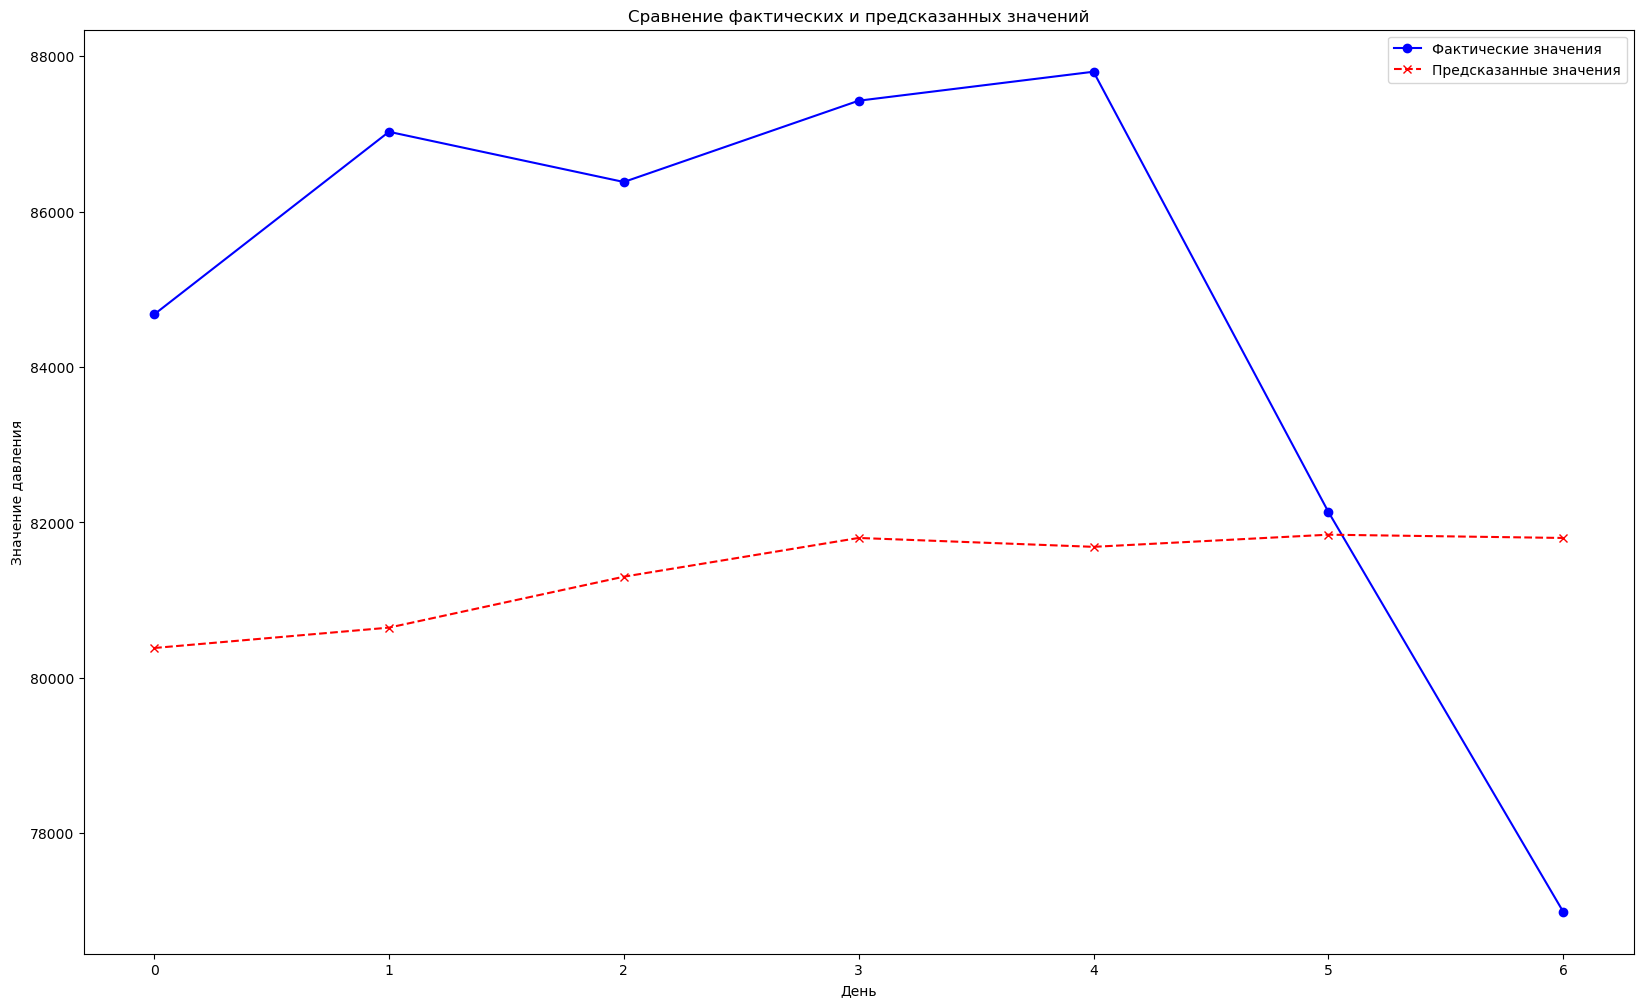

In [59]:
# график
plt.figure(figsize=(20, 12))

plt.plot(v[-7:], label='Фактические значения', marker='o', linestyle='-', color='b')
plt.plot(v7, label='Предсказанные значения', marker='x', linestyle='--', color='r')

plt.xlabel('День')
plt.ylabel('Значение давления')
plt.legend(loc='best')

plt.title('Сравнение фактических и предсказанных значений')

plt.show()

# Прогнозирование объёма по температуре (7 дней)

In [53]:
df_tv_7 = df_tv_7.drop(columns=['v'])

print(df_tv_7)

       t   t_1   t_2   t_3   t_4  t_5  t_6  t_7  t_8  t_9  ...      v_1  \
0    -18   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...      NaN   
1    -21 -18.0   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  38802.0   
2    -28 -21.0 -18.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  40640.0   
3    -21 -28.0 -21.0 -18.0   NaN  NaN  NaN  NaN  NaN  NaN  ...  42614.0   
4    -10 -21.0 -28.0 -21.0 -18.0  NaN  NaN  NaN  NaN  NaN  ...  42587.0   
...   ..   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...      ...   
4013  -5  -2.0  -1.0  -1.0   0.0  0.0  2.0 -1.0 -3.0  0.0  ...  87027.0   
4014  -9  -5.0  -2.0  -1.0  -1.0  0.0  0.0  2.0 -1.0 -3.0  ...  86381.0   
4015  -6  -9.0  -5.0  -2.0  -1.0 -1.0  0.0  0.0  2.0 -1.0  ...  87427.0   
4016  -4  -6.0  -9.0  -5.0  -2.0 -1.0 -1.0  0.0  0.0  2.0  ...  87800.0   
4017  -2  -4.0  -6.0  -9.0  -5.0 -2.0 -1.0 -1.0  0.0  0.0  ...  82136.0   

          v_2      v_3      v_4      v_5      v_6      v_7      v_8      v_9  \
0         NaN      

In [54]:
df_tv_7 = df_tv_7[10:]

In [55]:
# Число предсказываемых дней
num_days_to_predict = 7
v7p = []


v_end = v[-1]
t_end = t[-1]
#df_tv_test = df_tv[-7:] # tt_test
#df_tv = df_tv[z1:-7] # tt_train

for j in range(num_days_to_predict):
    print(t_end)
    print(v_end)
    # новая строка для предсказаний
    new_row = df_tv_7.iloc[-1].copy()
    
    
    # Сдвиг значения v и t
    for i in range(2, z1+1):
        new_row[f't_{i}'] = df_tv_7.iloc[-1][f't_{i - 1}']
        new_row[f'v_{i}'] = df_tv_7.iloc[-1][f'v_{i - 1}']
    new_row[f'v_1'] = v_end
    new_row[f't_1'] = t_end
    
    df_tv_7 = pd.concat([df_tv_7, new_row.to_frame().T], ignore_index=True) 

 #   print(df_tv[-2:-1])  
    
    # Получение последней строки в массиве df_tv
    last_row = df_tv_7.iloc[-1]

    feature_names = ['t', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10']
    last_row_df = pd.DataFrame([last_row.values], columns=feature_names)

    
    # Прогнозирование значения v для последней строки
    v_forecast = best_model.predict(last_row_df)
    v_end = v_forecast
    t_end = t7p[j]
    
    v7p = np.append(v7, v_forecast)

-2
76990
-2.017758212907847
[77194.25111137]
-3.0832756931776966
[77779.64237725]
-4.23276701486986
[78829.35461301]
-3.659375798269764
[79567.05569157]
-3.1660230597360868
[80322.20782593]
-2.9337900695436536
[80994.02734002]


In [56]:
print(v7p)

[80383.74387375 80646.08543975 81301.41972554 81800.09279226
 81685.72196932 81842.10782183 81799.94135764 82061.69202575]


In [57]:
print(t7p)

[-2.01775821 -3.08327569 -4.23276701 -3.6593758  -3.16602306 -2.93379007
 -4.1162641 ]


In [58]:
print("Температура на 7-ой день: ", t7p[6], "\nОбъём на 7-ой день: ", v7p[6])

Температура на 7-ой день:  -4.116264098262855 
Объём на 7-ой день:  81799.94135764072
